In [1]:
# import statements
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy 

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'C:/Classification/sevenone/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(dataloaders['train'])

cuda:0


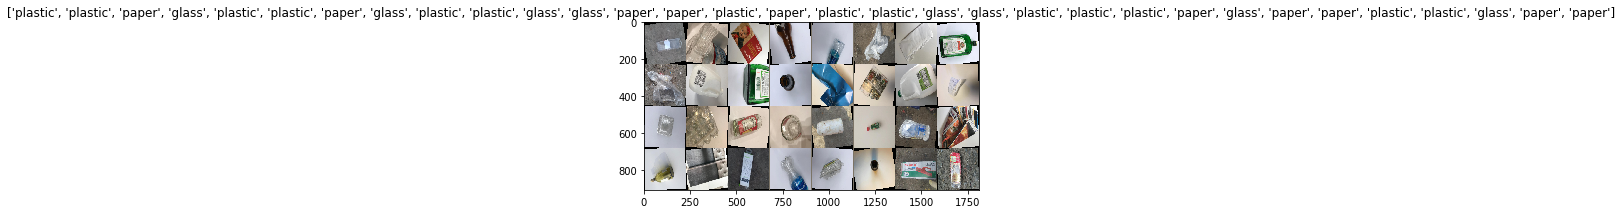

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
loss_array = {'train': [],
              'val' : []}
acc_array = {'train': [],
              'val' : []}

def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            loss_array[phase].append(epoch_loss)
            acc_array[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 4, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)        #Batch normalization
        self.relu = nn.ReLU()                 #RELU Activation
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)   #Maxpooling reduces the size by kernel size. 224/2 = 112
        
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)    #Size now is 112/2 = 56
        
        self.cnn3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=7,stride=1,padding=3)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)     #Size now is 56/2 = 28
        
        self.cnn4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=7,stride=1,padding=3)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)     #Size now is 28/2 = 14
        
        self.cnn5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=7,stride=1,padding=3)
        self.batchnorm5 = nn.BatchNorm2d(128)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2)     #Size now is 14/2 = 7
        
        
        self.fc1 = nn.Linear(in_features=6272, out_features=2048)   #Flattened image is fed into linear NN and reduced to half size
#         self.droput = nn.Dropout(p=0.4)                    #Dropout used to reduce overfitting
        self.fc2 = nn.Linear(in_features=2048, out_features=512)
#         self.droput = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(in_features=512, out_features=128)
#         self.droput = nn.Dropout(p=0.3)
        self.fc4 = nn.Linear(in_features=128, out_features=32)
        self.fc5 = nn.Linear(in_features=32,out_features=3)
#          Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.
       
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        
        out = self.cnn3(out)
        out = self.batchnorm3(out)
        out = self.relu(out)
        out = self.maxpool3(out)
        
        out = self.cnn4(out)
        out = self.batchnorm4(out)
        out = self.relu(out)
        out = self.maxpool4(out)
        
        out = self.cnn5(out)
        out = self.batchnorm5(out)
        out = self.relu(out)
        out = self.maxpool5(out)
        #Flattening is done here with .view() -> (batch_size, 32*16*16) = (100, 8192)
        out = out.view(-1,6272)   #-1 will automatically update the batchsize as 100; 8192 flattens 32,16,16
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
#         out = self.droput(out)
        out = self.fc2(out)
        out = self.relu(out)
#         out = self.droput(out)
        out = self.fc3(out)
        out = self.relu(out)
#         out = self.droput(out)
        out = self.fc4(out)
        out = self.fc5(out)
        return out

In [7]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda() 
    
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

In [56]:
# model

CNN(
  (cnn1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool4): MaxPool2

In [57]:
# model = train_model(model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0988 Acc: 0.3394
val Loss: 1.0953 Acc: 0.3484

Epoch 1/24
----------
train Loss: 1.0781 Acc: 0.4118
val Loss: 1.0754 Acc: 0.4704

Epoch 2/24
----------
train Loss: 1.0447 Acc: 0.5000
val Loss: 1.0397 Acc: 0.5122

Epoch 3/24
----------
train Loss: 0.9860 Acc: 0.5281
val Loss: 0.9818 Acc: 0.5296

Epoch 4/24
----------
train Loss: 0.9296 Acc: 0.5631
val Loss: 0.9670 Acc: 0.5401

Epoch 5/24
----------
train Loss: 0.9096 Acc: 0.6000
val Loss: 0.9531 Acc: 0.5401

Epoch 6/24
----------
train Loss: 0.9006 Acc: 0.6049
val Loss: 0.9353 Acc: 0.5540

Epoch 7/24
----------
train Loss: 0.8801 Acc: 0.6192
val Loss: 0.9164 Acc: 0.5784

Epoch 8/24
----------
train Loss: 0.8679 Acc: 0.6251
val Loss: 0.9077 Acc: 0.5749

Epoch 9/24
----------
train Loss: 0.8509 Acc: 0.6429
val Loss: 0.9044 Acc: 0.5819

Epoch 10/24
----------
train Loss: 0.8425 Acc: 0.6463
val Loss: 0.9025 Acc: 0.5679

Epoch 11/24
----------
train Loss: 0.8444 Acc: 0.6409
val Loss: 0.9003 Acc: 0.5854

Ep

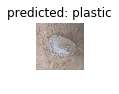

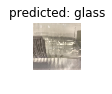

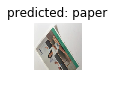

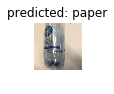

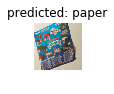

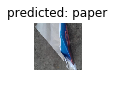

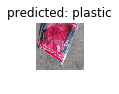

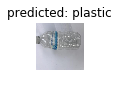

In [60]:
visualize_model(model)

plt.ioff()
plt.show()

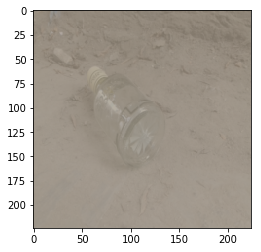

paper


In [8]:
from torch.autograd import Variable
from PIL import Image
imsize = 224
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image  #assumes that you're using GPU

image = image_loader('singleImg/j.jpg')
np_image = image.detach()
np_image = np.squeeze(np_image)
# print(np_image.shape)
# print(image.shape)
imshow(np_image)
# model_conv(image)


#passing image to model for classification
y_pred = model(image.cuda())
# print(y_pred)
_, preds = torch.max(y_pred, 1)
print(class_names[preds]) 

In [62]:
# torch.save(model.state_dict(),'final-built.pth')

In [9]:
model.load_state_dict(torch.load('final-built.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [64]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
# print("Confusion matrix: \ntrue value(Horizontal) vs predicted value(Vertical)")
# print(confusion_matrix)

In [65]:
conf_np = confusion_matrix.numpy()
probab_confuse = conf_np/conf_np.sum(axis=1)[:,None]
print('pred_glass pred_paper pred_plastic')
print('================================================')
print(np.around((probab_confuse * 100),decimals=1))

print('\n\n')
print('class based accuracy:')
print('=======================')
individual = confusion_matrix.diag()/confusion_matrix.sum(1)
print("glass:   ",individual[0])
print("paper:   ",individual[1])
print("plastic: ",individual[2])

pred_glass pred_paper pred_plastic
[[19.8 24.4 55.8]
 [ 5.  89.   6. ]
 [ 5.9 30.7 63.4]]



class based accuracy:
glass:    tensor(0.1977)
paper:    tensor(0.8900)
plastic:  tensor(0.6337)


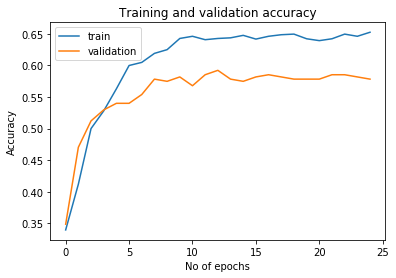

In [67]:
x = np.arange(25)
plt.title('Training and validation accuracy')
plt.xlabel("No of epochs")
plt.ylabel("Accuracy")

plt.plot(x, acc_array['train'])
plt.plot(x, acc_array['val'])
plt.legend(['train', 'validation'], loc='best')
plt.savefig('acc.png')

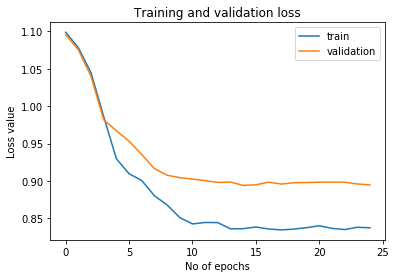

In [68]:
x = np.arange(25)
plt.title('Training and validation loss')
plt.xlabel("No of epochs")
plt.ylabel("Loss value")

plt.plot(x, loss_array['train'])
plt.plot(x, loss_array['val'])
plt.legend(['train', 'validation'], loc='best')
plt.savefig('loss.png')

In [71]:


def custom_viz(kernels, path=None, cols=None, size=None, verbose=False):
    """Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: Number of columns (doesn't work completely yet.)
    size: Tuple input for size. For example: size=(5,5)
    verbose: Print information about the input.
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        """ w, h: width, height in inches """
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
#     print(N)
    C = kernels.shape[1]
#     print(C)
    
    if verbose:
        print("Shape of input: ", kernels.shape)
    # If single channel kernel with HxW size,
    # plot them in a row.
    # Else, plot image with C number of columns.
    if cols==None:
        req_cols = C
    elif cols:
        req_cols = cols
    elif C>1:
        req_cols = C
    
    total_cols = N*C
#     print(total_cols)
#     req_cols = cols
#     print(req_cols)
    
    num_rows = int(np.ceil(total_cols/req_cols))
    pos = range(1,total_cols + 1)

    fig = plt.figure(figsize=(20,10))
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(num_rows,req_cols,pos[k])
            ax.imshow(img)
            plt.axis('off')
            k = k+1
    if size:
        size_h,size_w = size
        set_size(size_h,size_w,ax)
    if path:
        plt.savefig(path, dpi=100)
    plt.show()


torch.Size([16, 3, 3, 3])


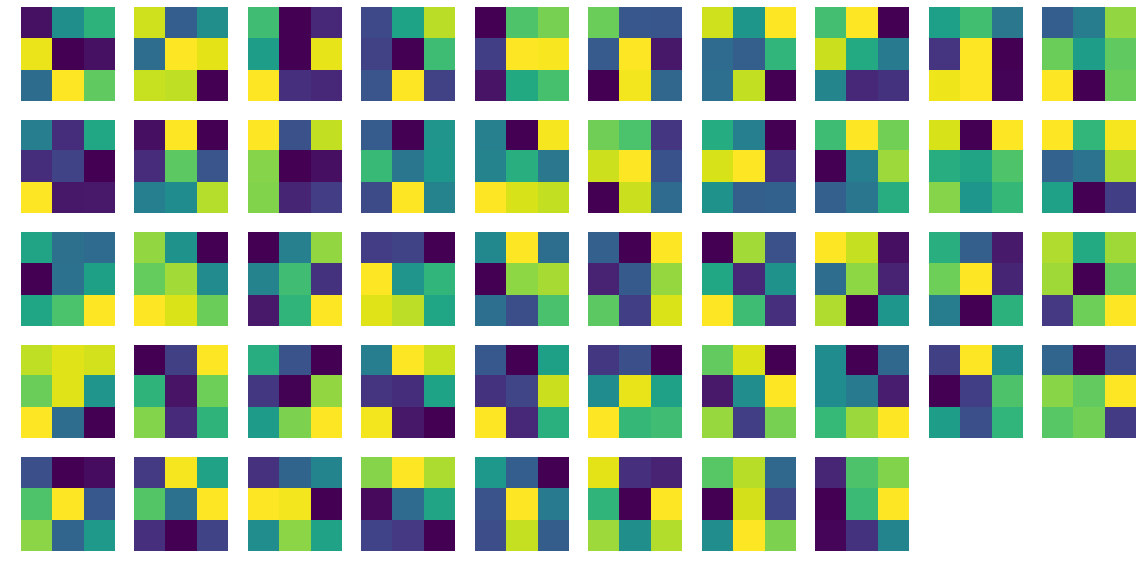

In [72]:
kernels = model.cnn1.weight.cpu().detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
print(kernels.shape)
custom_viz(kernels, 'conv1_weights.png', 10)


In [13]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x26337d05438>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x26337d05048>}

In [56]:
examples = iter(enumerate(dataloaders['train']))
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

torch.Size([32, 3, 224, 224])


In [57]:

from torch.autograd import Variable
def rotate_tensor(_in_tensor, plot=True):
    in_tensor = _in_tensor.clone()
    # Add one more channel to the beginning. Tensor shape = 1,1,28,28
    in_tensor.unsqueeze_(0)
    # Convert to Pytorch variable
    in_tensor = Variable(in_tensor, requires_grad=True)
    
    in_tensor_90 = in_tensor.transpose(2, 3).flip(3)
    in_tensor_180 = in_tensor.flip(2).flip(3)
    in_tensor_270 = in_tensor.transpose(2, 3).flip(2)
    
    if plot:
        plt.figure(1)
        plt.subplot(221)
        plt.gca().set_title('0 degree')
        plt.imshow(in_tensor[0][0].cpu().detach().clone())
        plt.subplot(222)
        plt.gca().set_title('+90 degree')
        plt.imshow(in_tensor_90[0][0].cpu().detach().clone())
        plt.subplot(223)
        plt.gca().set_title('+270 degree')
        plt.imshow(in_tensor_270[0][0].cpu().detach().clone())
        plt.subplot(224)
        plt.gca().set_title('+180 degree')
        plt.imshow(in_tensor_180[0][0].cpu().detach().clone())
        plt.tight_layout()
        plt.show()
    return(in_tensor, in_tensor_90, in_tensor_180, in_tensor_270)

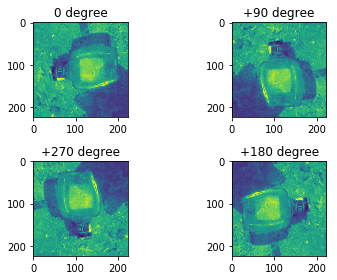

In [33]:
number, number_90, number_180, number_270 = rotate_tensor(example_data[1])

In [48]:
number.shape

torch.Size([1, 3, 224, 224])

In [34]:
print("Predicted Class: ", 
      np.argmax(model.forward(number.cuda()).cpu().detach().numpy()))

Predicted Class:  2


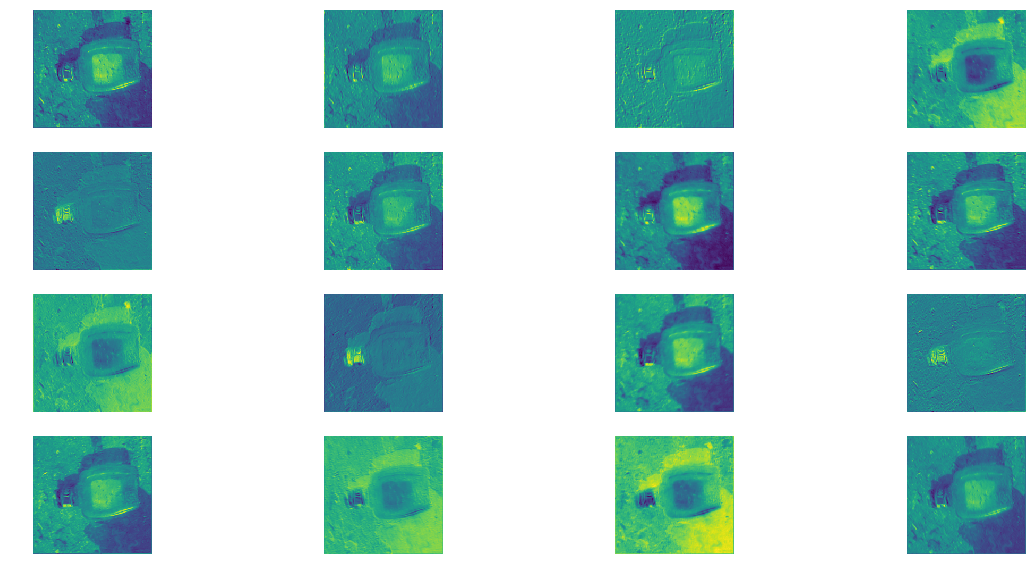

In [80]:
conv1_out = model.cnn1.forward(number.cuda()).cpu().detach()
conv1_out = conv1_out.permute(1,0,2,3)
conv1_out = conv1_out - conv1_out.min()
conv1_out = conv1_out / conv1_out.max()
conv1_out.shape
custom_viz(conv1_out, 'conv1_actv.png',4)

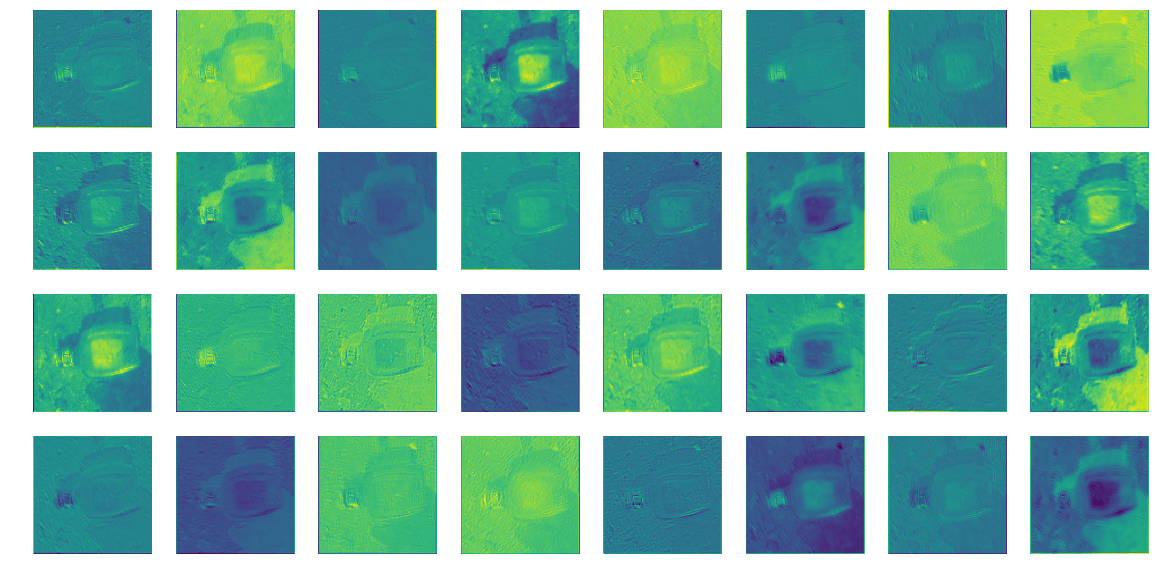

In [110]:
# conv1_out.shape
conv1_o = conv1_out
conv1_o.shape
conv2_out = model.cnn2.forward(conv1_o.cuda()).cpu().detach()
conv2_out = conv2_out.permute(1,0,2,3)
conv2_out = conv2_out - conv2_out.min()
conv2_out = conv2_out / conv2_out.max()
conv2_out.shape
custom_viz(conv2_out, 'conv1_actv.png',8)

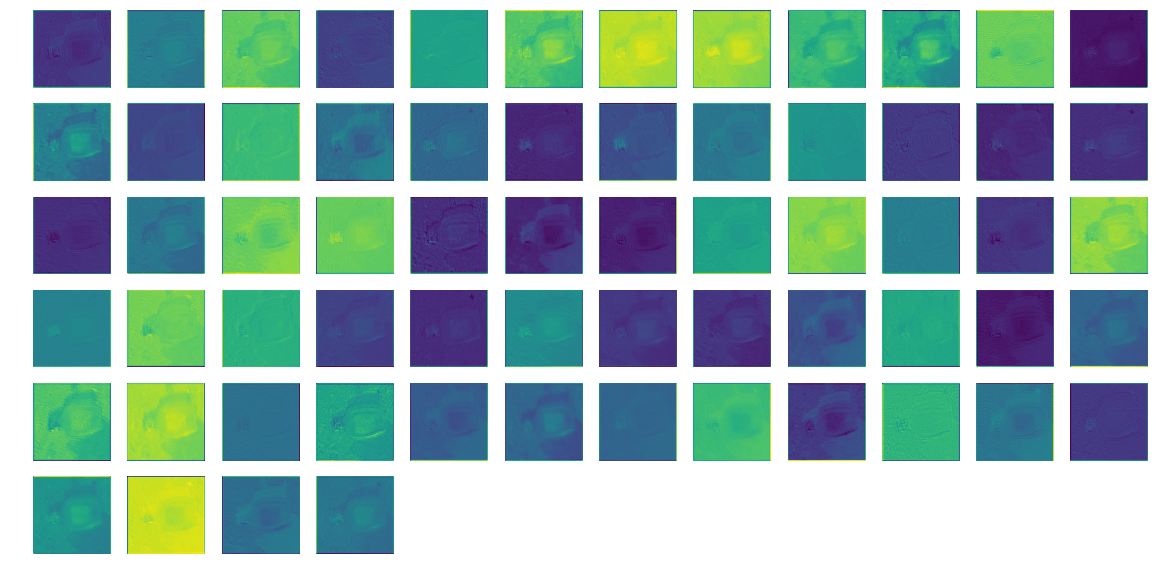

In [126]:
conv2_o = conv2_out.permute(1,0,2,3)
conv2_o.shape
conv3_out = model.cnn3.forward(conv2_o.cuda()).cpu().detach()
conv3_out = conv3_out.permute(1,0,2,3)
conv3_out = conv3_out - conv3_out.min()
conv3_out = conv3_out / conv3_out.max()
conv3_out.shape
custom_viz(conv3_out, 'conv1_actv.png',12)

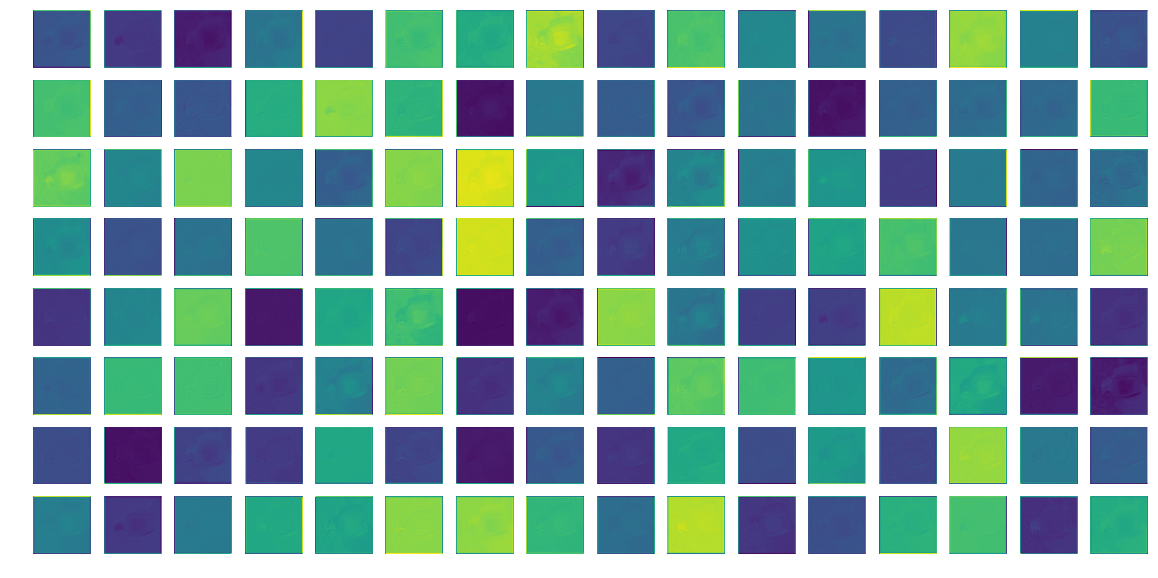

In [128]:
conv3_o = conv3_out.permute(1,0,2,3)
conv3_o.shape
conv4_out = model.cnn4.forward(conv3_o.cuda()).cpu().detach()
conv4_out = conv4_out.permute(1,0,2,3)
conv4_out = conv4_out - conv3_out.min()
conv4_out = conv4_out / conv3_out.max()
conv4_out.shape
custom_viz(conv4_out, 'conv1_actv.png',16)